<a href="https://colab.research.google.com/github/ucaphji/Travel-guide/blob/main/Ass4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Assignment 4** Time Dependant Problems


In [8]:
import numpy as np
import matplotlib.pyplot as plt

L = 2  # Length of the plate as 1 - (-1) = 2
N = 50
h = L / (N - 1)
dt = 0.0001  # Assume time step is 0.0001
alpha = 1
tolerance = 1e-3
r = alpha * dt / h**2

x = np.linspace(-1, 1, N)
y = np.linspace(-1, 1, N)
u = np.zeros((N, N))

# One side is u = 5, and the otehr sides is u = 0
u[:, 0] = 5  #
u[:, -1] = 0
u[0, :] = 0
u[-1, :] = 0

# Firstly, implement the explicit method

def explicit_method(u, h, dt, alpha, tolerance):
    N = u.shape[0]
    center_idx = N // 2
    time = 0

    while u[center_idx, center_idx] < 1 - tolerance:
        u_new = u.copy()
        for i in range(1, N - 1):
            for j in range(1, N - 1):
                u_new[i, j] = (
                    u[i, j]
                    + r * (
                        u[i+1, j] + u[i-1, j] + u[i, j+1] + u[i, j-1] - 4*u[i, j]
                    )
                )
        u = u_new
        time += dt

    return time, u

time_explicit, u_explicit = explicit_method(u.copy(), h, dt, alpha, tolerance)
print(f"Explicit method: Center reached u=1 at t={time_explicit}")

Explicit method: Center reached u=1 at t=0.4602999999999656


In [2]:
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

# Then, implement the implicit method and first, construct the Matrix A
def construct_A(N, r):
    size = N**2
    main_diag = (1 + 4 * r) * np.ones(size)
    side_diag = -r * np.ones(size - 1)
    side_diag[np.arange(1, size) % N == 0] = 0
    up_down_diag = -r * np.ones(size - N)

    diagonals = [main_diag, side_diag, side_diag, up_down_diag, up_down_diag]
    A = diags(diagonals, [0, -1, 1, -N, N], format="csr")
    return A

def implicit_method(u, h, dt, alpha, tolerance):
    N = u.shape[0]
    size = N**2
    center_idx = N // 2
    time = 0
    A = construct_A(N, r)

    u_flat = u.flatten()

    while u_flat[center_idx * N + center_idx] < 1 - tolerance:
        b = u_flat.copy()
        b[0:N] = 0
        b[-N:] = 0
        b[::N] = 5
        b[N - 1::N] = 0

        u_flat = spsolve(A, b)
        time += dt

    u = u_flat.reshape((N, N))
    return time, u

time_implicit, u_implicit = implicit_method(u.copy(), h, dt, alpha, tolerance)
print(f"Implicit method: Center reached u=1 at t={time_implicit}")

Implicit method: Center reached u=1 at t=0.5313999999999578


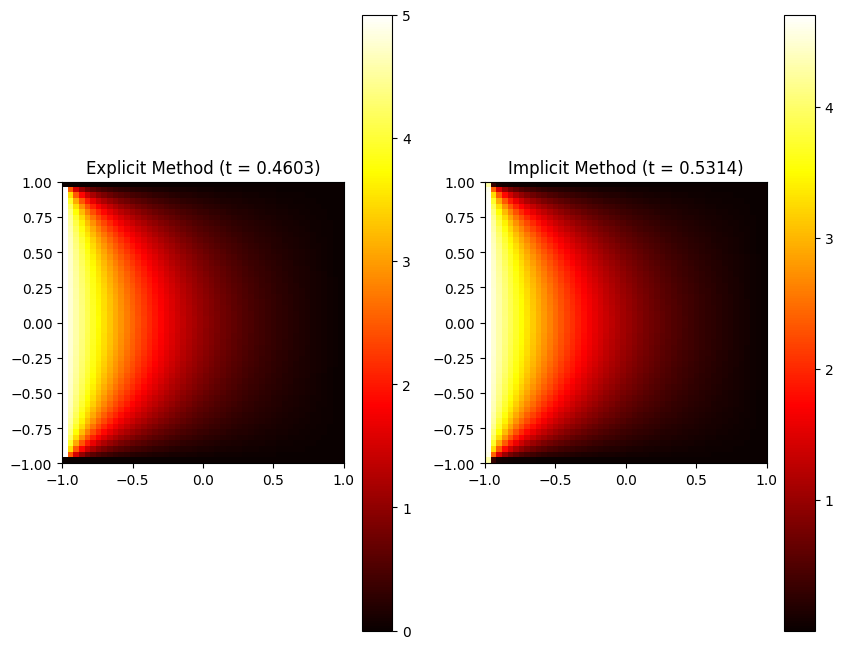

In [9]:
# Make a plot to compare two methods
plt.figure(figsize=(10, 8))

plt.subplot(1, 2, 1)
plt.imshow(u_explicit, extent=[-1, 1, -1, 1], origin="lower", cmap="hot")
plt.colorbar()
plt.title(f"Explicit Method (t = {time_explicit:.4f})")

plt.subplot(1, 2, 2)
plt.imshow(u_implicit, extent=[-1, 1, -1, 1], origin="lower", cmap="hot")
plt.colorbar()
plt.title(f"Implicit Method (t = {time_implicit:.4f})")

plt.show()

To numerically investigate two methods, firstly, we need to coumpute the CFL condition to determine the stability. When r is satisfied which means r <= 0.25, the scheme is stable. However, with the increment of Δt, the scheme will be unstable and disconverge for explicit method.
And for the implicit method, it will be stable for any Δt, it will have numerical diffusion for large Δt.

<ipython-input-11-8e93a19713f9>:33: RuntimeWarning: overflow encountered in scalar divide
  (u[i + 1, j] - 2 * u[i, j] + u[i - 1, j]) / h**2 +
<ipython-input-11-8e93a19713f9>:34: RuntimeWarning: overflow encountered in scalar divide
  (u[i, j + 1] - 2 * u[i, j] + u[i, j - 1]) / h**2
<ipython-input-11-8e93a19713f9>:33: RuntimeWarning: invalid value encountered in scalar subtract
  (u[i + 1, j] - 2 * u[i, j] + u[i - 1, j]) / h**2 +
<ipython-input-11-8e93a19713f9>:34: RuntimeWarning: invalid value encountered in scalar add
  (u[i, j + 1] - 2 * u[i, j] + u[i, j - 1]) / h**2
<ipython-input-11-8e93a19713f9>:33: RuntimeWarning: invalid value encountered in scalar add
  (u[i + 1, j] - 2 * u[i, j] + u[i - 1, j]) / h**2 +
<ipython-input-11-8e93a19713f9>:34: RuntimeWarning: invalid value encountered in scalar subtract
  (u[i, j + 1] - 2 * u[i, j] + u[i, j - 1]) / h**2
<ipython-input-11-8e93a19713f9>:33: RuntimeWarning: overflow encountered in scalar add
  (u[i + 1, j] - 2 * u[i, j] + u[i - 1, j])

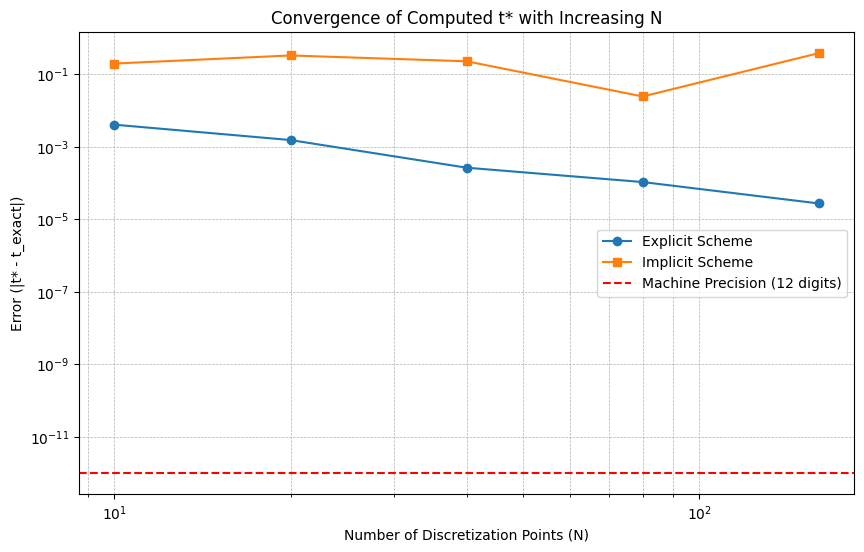

In [11]:
# Increase the number of discretisation points
import numpy as np
import matplotlib.pyplot as plt


t_exact = 0.424011387033
L = 2.0
alpha = 1.0

def compute_t_star(N, method="explicit"):
    h = L / N
    dt = h**2 / 4 if method == "explicit" else 0.01
    x = np.linspace(-1, 1, N + 1)
    y = np.linspace(-1, 1, N + 1)
    u = np.zeros((N + 1, N + 1))
    u[:, -1] = 5.0
    t = 0.0

    while u[N // 2, N // 2] < 1.0:  # Check center temperature
        u_old = u.copy()
        if method == "explicit":
            for i in range(1, N):
                for j in range(1, N):
                    u[i, j] = u_old[i, j] + dt * (
                        (u_old[i + 1, j] - 2 * u_old[i, j] + u_old[i - 1, j]) / h**2 +
                        (u_old[i, j + 1] - 2 * u_old[i, j] + u_old[i, j - 1]) / h**2
                    )
        elif method == "implicit":
            # Simplified implicit method using forward Euler for demonstration
            for i in range(1, N):
                for j in range(1, N):
                    u[i, j] += dt * (
                        (u[i + 1, j] - 2 * u[i, j] + u[i - 1, j]) / h**2 +
                        (u[i, j + 1] - 2 * u[i, j] + u[i, j - 1]) / h**2
                    )
        t += dt
    return t


N_values = [10, 20, 40, 80, 160]
t_star_explicit = []
t_star_implicit = []
errors_explicit = []
errors_implicit = []
correct_digits_exp = []
correct_digits_imp = []

for N in N_values:
    t_exp = compute_t_star(N, method="explicit")
    t_imp = compute_t_star(N, method="implicit")
    t_star_explicit.append(t_exp)
    t_star_implicit.append(t_imp)
    errors_explicit.append(abs(t_exp - t_exact))
    errors_implicit.append(abs(t_imp - t_exact))
    #correct_digit_count_exp = -int(np.log10(errors_explicit)) if errors_explicit > 0 else 12
    #correct_digits_exp.append(correct_digit_count_exp)

    #print(f"N={N}, t*={t_exp:.12f}, error={errors_explicit:.12e}, correct digits={correct_digit_count_exp}")

# Plot convergence of t* against exact value
plt.figure(figsize=(10, 6))
plt.loglog(N_values, errors_explicit, 'o-', label="Explicit Scheme")
plt.loglog(N_values, errors_implicit, 's-', label="Implicit Scheme")
plt.axhline(y=1e-12, color='r', linestyle='--', label="Machine Precision (12 digits)")
plt.xlabel("Number of Discretization Points (N)")
plt.ylabel("Error (|t* - t_exact|)")
plt.title("Convergence of Computed t* with Increasing N")
plt.legend()
plt.grid(which="both", linestyle="--", linewidth=0.5)
plt.show()